In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
import os
from pathlib import Path

In [3]:
sys.path.append('../src')
from physics.RICH_simulator import RICHSimulator
from physics import constants
from utils import visualisations, metrics



In [4]:
#data_path = Path('../data/processed/rich_images.npz')
data_path = Path('../data/processed/rich_images_combined_events.npz')
# Load the dataset
data = np.load(data_path)
images = data['images']

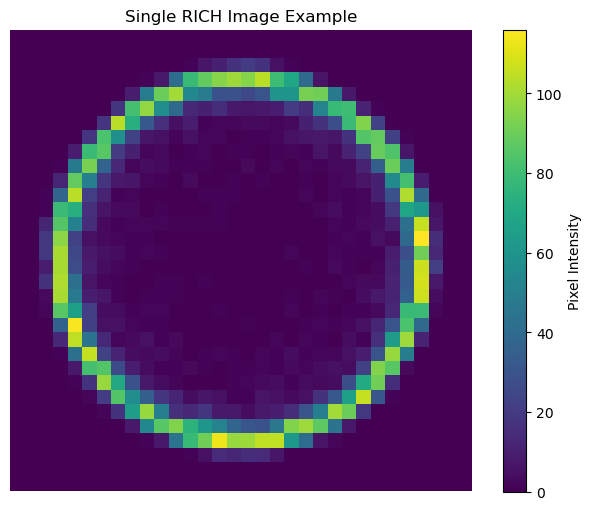

In [5]:
# Display a grid of 9 images
#visualisations.display_image_grid(images, num_images=9)
plt.figure(figsize=(8, 6))
img = plt.imshow(images[40], cmap='viridis')
plt.title('Single RICH Image Example')
plt.colorbar(img, label='Pixel Intensity')
plt.axis('off')
plt.show()

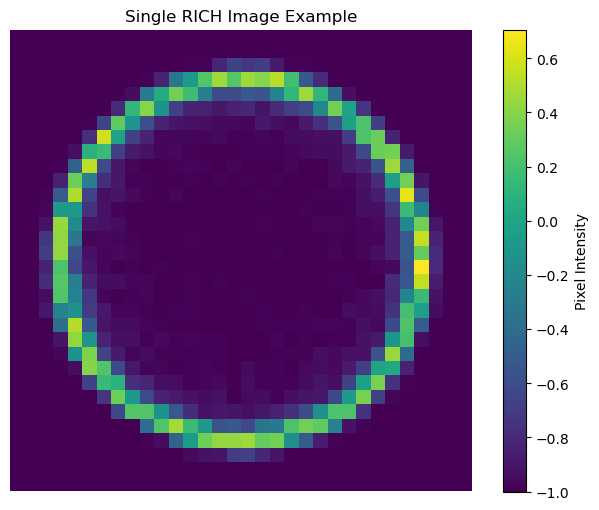

In [6]:
# Normalise images for Diffusion modelling
max_value = np.max(images)
#normalised_images = metrics.normalise_rich_images(images, max_value)
normalised_images = (images / max_value) * 2 - 1  # Scale to [-1, 1]
#normalised_images = (images - np.mean(images)) / np.std(images)
plt.figure(figsize=(8, 6))
img = plt.imshow(normalised_images[4], cmap='viridis')
plt.title('Single RICH Image Example')
plt.colorbar(img, label='Pixel Intensity')
plt.axis('off')
plt.show()

In [7]:
# Ensure correct shape: (num_samples, height, width, channels)
if len(normalised_images.shape) == 3:
    normalised_images = normalised_images[..., np.newaxis]

print(f"Dataset shape: {normalised_images.shape}")
print(f"Value range: [{normalised_images.min():.3f}, {normalised_images.max():.3f}]")


Dataset shape: (1000, 32, 32, 1)
Value range: [-1.000, 1.000]


In [8]:
from ml.diffusion.rich_ddpm import RICHDDPM
from ml.diffusion.trainer import RICHTrainer
from ml.diffusion.unet import UNet
from ml.diffusion.unet_pytorch import PyTorchUNet
from ml.diffusion.visualiser import RICHVisualiser

In [9]:
IMAGE_SIZE = 32
TIMESTEPS = 1000
BATCH_SIZE = 2  # Small for debugging
EPOCHS = 3
LEARNING_RATE = 1e-6

print("Step 1: Creating and verifying DDPM...")
ddpm = RICHDDPM(image_size=IMAGE_SIZE, timesteps=TIMESTEPS)

print("\nStep 2: Running comprehensive alpha verification...")
alpha_ok = ddpm.verify_alpha_calculations()

if not alpha_ok:
    print("❌ Alpha verification failed! Fix this before proceeding.")
    exit(1)

print("\nStep 3: Testing noise addition with sample image...")
sample_image = normalised_images[0:1]
test_timesteps = [0, TIMESTEPS//2, TIMESTEPS-1]

for t in test_timesteps:
    ddpm.debug_noise_addition(sample_image, t)

print("\nStep 4: Verifying variance preservation...")
variance_ok = ddpm._verify_variance_preservation()

if not variance_ok:
    print("❌ Variance preservation failed! Fix this before training.")
    exit(1)

print("\nStep 5: All verifications passed! Proceeding with training...")

Step 1: Creating and verifying DDPM...
=== Basic Alpha Verification ===
α_0: 0.999900 (should be close to 1)
α_999: 0.800000 (should be close to 0)
√ᾱ_0: 0.999950 (should be 1)
√ᾱ_999: 0.000000 (should be close to 0)
✅ Basic verification completed
DDPM initialized: image_size=32, timesteps=1000
Beta range: [0.000100, 0.200000]

Step 2: Running comprehensive alpha verification...

COMPREHENSIVE ALPHA CALCULATIONS VERIFICATION

1. Alpha progression check:
   α_0: 0.999900
   α_250: 0.949875
   α_500: 0.899850
   α_750: 0.849825
   α_999: 0.800000
✅ ᾱ_t calculation is correct (cumulative product of α_t)

2. √ᾱ_t progression:
   √ᾱ_0: 0.999950 (should be 1.0)
   √ᾱ_999: 0.000000 (should be close to 0)

3. √(1-ᾱ_t) progression:
   √(1-ᾱ_0): 0.010001 (should be 0.0)
   √(1-ᾱ_999): 1.000000 (should be close to 1)

4. Mathematical property check:
   At t=500: ᾱ_t + (1-ᾱ_t) = 0.000000 + 1.000000 = 1.000000 (should be 1.0)
✅ Mathematical property verified

🎉 All alpha calculations ver

In [ ]:
import torch
import numpy as np
from ml.diffusion.richddpm_pytorch import RICHDDPM
from ml.diffusion.unet_pytorch import PyTorchUNet
from ml.diffusion.visualiser_pytorch import RICHVisualiser, StochasticProcessVisualiser
from ml.diffusion.trainer_pytorch import RICHTrainer

# Configuration
IMAGE_SIZE = 32
TIMESTEPS = 1000
BATCH_SIZE = 200 #1000
EPOCHS = 1 #50 #100
LEARNING_RATE = 1e-4

# Initialize components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ddpm = RICHDDPM(image_size=IMAGE_SIZE, timesteps=TIMESTEPS)
unet = PyTorchUNet(image_size=IMAGE_SIZE, in_channels=1, base_channels=32)
visualizer = RICHVisualiser()
trainer = RICHTrainer(ddpm, unet, visualizer, learning_rate=LEARNING_RATE)

# Visualize forward process (convert to numpy for visualization)
sample_image = torch.FloatTensor(normalised_images[0:1])  # Shape: (1, 32, 32, 1)
sample_image = sample_image.permute(0, 3, 1, 2).to(device)  # Convert to channel-first
visualizer.plot_forward_process(ddpm, sample_image)

# Train the model - THIS IS WHERE training_step GETS CALLED!
trainer.train(normalised_images, epochs=EPOCHS, batch_size=BATCH_SIZE)
visualizer.plot_reverse_process(ddpm, unet, num_steps=8)
# Generate final samples
#print("\nGenerating final samples...")
#final_samples, intermediate_samples = ddpm.generate_samples(unet, num_samples=5)



DDPM initialized on device: cpu
PyTorch UNet initialized with 14,169,281 parameters
RICHVisualiser initialised. Output directory: rich_diffusion_visualisations
Trainer initialized on device: cpu
Learning rate: 0.0001
Forward process visualisation saved: forward_diffusion_process.png
Starting training on 1000 images
Epochs: 1, Batch size: 200
Steps per epoch: 5
Epoch 1/1, Batch 0/5, Loss: 1.081452
Epoch 1/1, Batch 1/5, Loss: 0.989544


In [ ]:
# === Visualise Generated Rings (Undo Scaling) ===

# Number of samples to generate
num_gen = 2
final_samples, intermediate_samples = ddpm.generate_samples(unet, num_samples=num_gen)

# Convert generated samples to numpy and undo scaling
for i in range(num_gen):
    gen_tensor = final_samples[i:i+1]  # shape: (1, C, H, W)
    gen_np = visualizer._tensor_to_numpy(gen_tensor)  # (1, H, W, C)
    
    # Undo [-1,1] scaling back to [0, max_value]
    gen_rescaled = ((gen_np[0, :, :, 0] + 1) / 2.0) * max_value
    
    # Show image
    plt.imshow(gen_rescaled, cmap=visualizer.cmap)
    plt.title(f"Generated Ring {i+1}")
    plt.axis("off")
    plt.colorbar()
    plt.show()

NameError: name 'ddpm' is not defined

In [ ]:
from scipy.stats import norm
from ml.diffusion.visualiser_pytorch import StochasticProcessVisualiser, DiffusionAnalysisVisualiser
# Create stochastic analysis before training
stochastic_vis = StochasticProcessVisualiser()
stochastic_vis.plot_stochastic_process_illustration()

Stochastic process illustration saved: stochastic_process.png


In [ ]:
analyser = DiffusionAnalysisVisualiser()
# Plot 1: Variance schedule analysis
analyser.plot_variance_schedule(ddpm)
    
# Plot 2: ELBO components analysis
analyser.plot_elbo_components(ddpm)
    
# Plot 3: Reparameterization trick importance
analyser.plot_reparameterization_trick(ddpm)
    
# Plot 4: Jensen's inequality in VLB
analyser.plot_jensen_inequality_analysis(ddpm)
    
# Plot 5: Training dynamics (if trainer available)
if trainer is not None:
    analyser.plot_training_dynamics(trainer)

NameError: name 'ddpm' is not defined